In [1]:
"""

"""

'\n\n'

In [2]:
is_skip = True
# Data params
batch_size = 128
min_encode_len = 30
max_encode_len = 100
pred_len = 30
padding_val = 0

valid_start_date = "2020-01-01"

# Model params
d_model = 256
nhead = 8
d_ff = 512
dropout = 0.3
num_layers = 8

# Import

In [3]:
import joblib
import copy
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from tqdm import tqdm

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

device = torch.device("cuda:0")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data, df_meta, min_size):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    sales_max = data["sales"].max()

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")

    # # Accumulate sales
    # data = data.sort_values(["article_id", "t_dat"]).reset_index(drop=True)
    # data["sales"] = data.groupby("article_id")["sales"].cumsum()

    # Temporal information
    temporal_cols = ["price", "day_sin", "day_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    data["day"] = data["t_dat"].dt.day
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month

    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    append_cyclic("day", 365)
    append_cyclic("dow", 7)
    append_cyclic("month", 12)
    
    # Data to list
    data = data.groupby("article_id", as_index=False)[["sales"] + temporal_cols].agg(list)

    # Size restriction
    data["size"] = data["sales"].str.len()
    data = data[data["size"] >= min_size]

    # Static info
    static_cols = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]
    data = pd.merge(data, df_meta[["article_id"] + static_cols], on="article_id")

    return data, static_cols, temporal_cols, sales_max

if not is_skip:
    df_prep = df_raw.copy()
    
    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train, static_cols, temporal_cols, sales_max = preprocess(df_train, df_meta, min_size=min_encode_len+pred_len)
    df_train.to_parquet("df_train.pq")
    joblib.dump(static_cols, "static_cols.pkl")
    joblib.dump(temporal_cols, "temporal_cols.pkl")
    joblib.dump(sales_max, "sales_max.pkl")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid, _, _, _ = preprocess(df_valid, df_meta, min_size=min_encode_len+pred_len)
    df_valid.to_parquet("df_valid.pq")

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
static_cols = joblib.load("static_cols.pkl")
temporal_cols = joblib.load("temporal_cols.pkl")
sales_max = joblib.load("sales_max.pkl")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, pred_len, min_encode_len, max_encode_len, static_cols, sales_max, is_valid=False):
        self.pred_len, self.min_encode_len, self.max_encode_len, self.is_valid = pred_len, min_encode_len, max_encode_len, is_valid
            
        # Sales
        self.sales_original = data["sales"].values
        self.sales = self.sales_original
        # self.sales = (self.sales_original/sales_max) + (1e-5)
        # Temporal
        self.temporal = data[temporal_cols].values
        # Static
        self.static = data[static_cols].values
    
    def __len__(self):
        return self.sales.shape[0]

    def get_prediction_idx(self, seq_len):
        idx_seq = np.arange(0, seq_len)
        filtered_idx_seq = np.where(
                            (idx_seq >= self.min_encode_len)
                            &(idx_seq <= seq_len - self.pred_len)
                            )[0]
        pred_start_idx = np.random.randint(filtered_idx_seq[0], filtered_idx_seq[-1]+1)
        prediction_idx = idx_seq[pred_start_idx : pred_start_idx+self.pred_len]
        return prediction_idx
    
    def get_encode_idx(self, pred_start_idx, seq_len):
        idx_seq = np.arange(0, seq_len)
        encode_len = np.random.randint(self.min_encode_len, min(pred_start_idx, self.max_encode_len)+1)
        encode_start_idx = pred_start_idx - encode_len
        encode_idx = idx_seq[encode_start_idx:encode_start_idx+encode_len]

        return encode_idx
    
    def __getitem__(self, idx):
        # Sales
        sales = self.sales[idx].reshape(-1, 1)
        sales = np.log1p(sales) + (1e-5)
        sales_original = self.sales_original[idx].reshape(-1,1)
        # Temporal
        temporal = np.array([np.array(i) for i in self.temporal[idx]]).T

        # X, y split
        prediction_idx = self.get_prediction_idx(seq_len=sales.shape[0])
        encode_idx = self.get_encode_idx(prediction_idx[0], seq_len=sales.shape[0])

        if not self.is_valid:
            hist = sales[encode_idx]
            temporal = temporal[encode_idx, :]
            y = sales[prediction_idx]
            y_original = sales_original[prediction_idx]
        else:
            hist = sales[:-self.pred_len]
            y = sales[-self.pred_len:]
            y_original = sales_original[-self.pred_len:]

        # Static
        static = self.static[idx]

        return {"hist": hist,
                "temporal": temporal,
                "static": static,
                "y": y,
                "y_original": y_original,
                }

def collate_fn(batch_list):
    hist = [torch.FloatTensor(batch["hist"]) for batch in batch_list]
    temporal = [torch.FloatTensor(batch["temporal"]) for batch in batch_list]
    static = np.array([batch["static"] for batch in batch_list])

    y = np.array([batch["y"] for batch in batch_list])
    y_original = np.array([batch["y_original"] for batch in batch_list])

    # Padding
    hist = torch.nn.utils.rnn.pad_sequence(hist, padding_value=0, batch_first=True)
    temporal = torch.nn.utils.rnn.pad_sequence(temporal, padding_value=0, batch_first=True)
    # Tokenizing
    static = tokenizer(static.flatten().tolist(), return_tensors="pt", padding=True, add_special_tokens=False)
    
    return {"hist": torch.FloatTensor(hist),
            "temporal": torch.FloatTensor(temporal),
            "static": static,
            "y": torch.FloatTensor(y),
            "y_original": torch.FloatTensor(y_original)
            }

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = Dataset(df_train, pred_len, min_encode_len, max_encode_len, static_cols, sales_max)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, pred_len, min_encode_len, max_encode_len, static_cols, sales_max, is_valid=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for data in train_dataloader:
    print("hist:", data["hist"].shape)
    print("temporal:", data["temporal"].shape)
    print("static:", data["static"]["input_ids"].shape)
    print("y:", data["y"].shape)
    break

hist: torch.Size([128, 100, 1])
temporal: torch.Size([128, 100, 7])
static: torch.Size([1536, 9])
y: torch.Size([128, 30, 1])


# Architecture

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout, pred_len):
        super().__init__()
        self.pred_len = pred_len
        self.regressor_token = torch.nn.Parameter(torch.randn(1, 1, d_model))

        # Temporal encoder
        self.temporal_linear = torch.nn.LSTM(7, d_model)
        self.temporal_encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout, batch_first=True), num_layers)

        # Static encoder
        configuration = BertConfig(hidden_size=d_model, num_hidden_layers=num_layers, num_attention_heads=nhead, intermediate_size=d_ff, hidden_dropout_prob=dropout, attention_probs_dropout_prob=dropout)
        self.static_embedder = BertModel(configuration).to(device)

        # Decoder
        self.hist_linear = torch.nn.LSTM(1, d_model)
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, dropout=dropout, batch_first=True), num_layers)
        self.decoder_linear = torch.nn.Linear(d_model*2, d_model)

        # Final
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        self.mse_linear1 = torch.nn.Linear(d_model, d_model*pred_len)
        self.mse_linear2 = torch.nn.Linear(d_model, 1)
        
        self.binary_linear1 = torch.nn.Linear(d_model, d_model*pred_len)
        self.binary_linear2 = torch.nn.Linear(d_model, 1)

        self.non_negative = torch.nn.ReLU()
    
    def forward(self, hist, temporal, static):
        # Mask
        hist_key_padding_mask = torch.where(hist.squeeze(-1)==0, -torch.inf, 0)
        hist_key_padding_mask = torch.concat([torch.zeros(hist_key_padding_mask.shape[0], 1).to(device), hist_key_padding_mask], dim=-1)

        temporal_key_padding_mask = torch.where(hist.squeeze(-1)==0, -torch.inf, 0)
        static_key_padding_mask = torch.where(static["attention_mask"]==1, 0, -torch.inf).reshape(hist.shape[0], -1)

        # Temporal encoder
        temporal_linear, _ = self.temporal_linear(temporal)
        temporal_encoder_output = self.temporal_encoder(temporal_linear)

        # Static encoder
        static_encoder_output = self.static_embedder(**static).last_hidden_state.reshape(hist.shape[0], -1, d_model)

        # Decoder
        hist_linear, _ = self.hist_linear(hist)
        hist_linear = torch.concat([self.regressor_token.repeat(hist.shape[0], 1,1), hist_linear], dim=1)
        decoder_temporal_output = self.decoder(tgt=hist_linear, memory=temporal_encoder_output, tgt_key_padding_mask=hist_key_padding_mask, memory_key_padding_mask=temporal_key_padding_mask)
        decoder_static_output = self.decoder(tgt=hist_linear, memory=static_encoder_output, tgt_key_padding_mask=hist_key_padding_mask, memory_key_padding_mask=static_key_padding_mask)

        decoder_output = torch.concat([decoder_temporal_output, decoder_static_output], dim=-1)
        decoder_output = self.relu(self.decoder_linear(decoder_output))        

        # Final
        mse = self.relu(self.mse_linear1(decoder_output[:, 0, :])).reshape(-1, self.pred_len, d_model)
        mse = self.mse_linear2(mse)

        binary = self.relu(self.binary_linear1(decoder_output[:, 0, :])).reshape(-1, self.pred_len, d_model)
        binary = self.sigmoid(self.binary_linear2(binary))

        return mse, binary

model = Transformer(d_model, num_layers, nhead, d_ff, dropout, pred_len)
model.to(device)
summary(model,
        data["hist"].to(device),
        data["temporal"].to(device),
        data["static"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #
     Transformer                  LSTM-1     [128, 100, 256], [1, 100, 256], [1, 100, 256]         271,360         271,360
     Transformer    TransformerEncoder-2                                   [128, 100, 256]      10,520,576      10,520,576
     Transformer             BertModel-3                                    [1536, 9, 256]      12,228,352      12,228,352
     Transformer                  LSTM-4     [128, 100, 256], [1, 100, 256], [1, 100, 256]         265,216         265,216
     Transformer    TransformerDecoder-5                                   [128, 101, 256]      12,630,016      12,630,016
     Transformer                Linear-6                                   [128, 101, 256]         131,328         131,328
     Transformer

'--------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                      Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n     Transformer                  LSTM-1     [128, 100, 256], [1, 100, 256], [1, 100, 256]         271,360         271,360\n     Transformer    TransformerEncoder-2                                   [128, 100, 256]      10,520,576      10,520,576\n     Transformer             BertModel-3                                    [1536, 9, 256]      12,228,352      12,228,352\n     Transformer                  LSTM-4     [128, 100, 256], [1, 100, 256], [1, 100, 256]         265,216         265,216\n     Transformer    TransformerDecoder-5                                   [128, 101, 256]      12,630,016      12,630,016\n     Tr

# Train

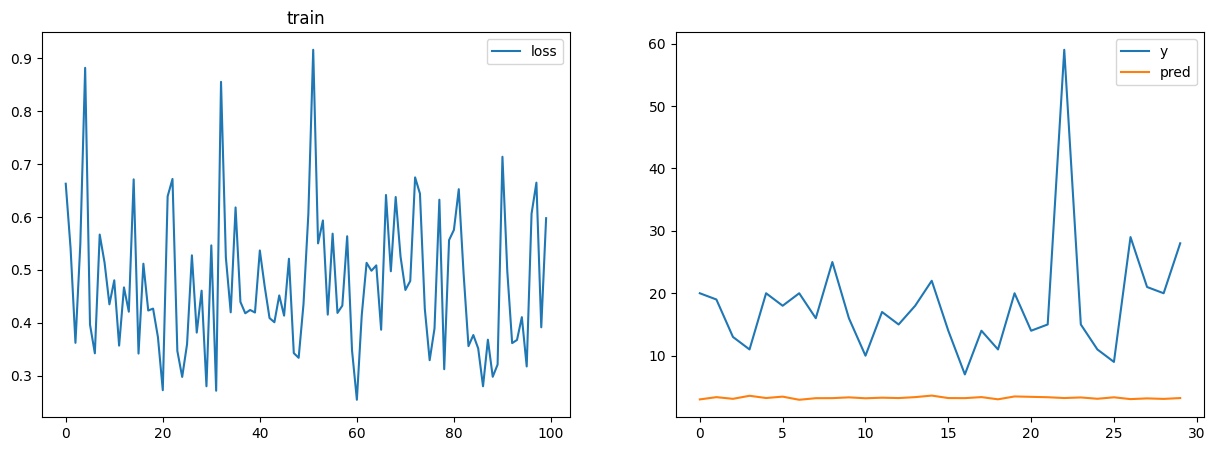

epoch 0 - loss: 0.47387:  26%|██▌       | 131/505 [01:24<03:59,  1.56it/s]

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss(reduction="none")
# mse_loss = torch.nn.MSELoss()

def mse_loss_fn(pred, y, y_original):
    mask = torch.where(y_original<=0, 0, 1).type(torch.FloatTensor).to(device)
    loss = mse_loss(pred, y)
    masked_loss = loss * mask
    
    negval_penalty = torch.max(0 - pred, torch.zeros(pred.shape).to(device))
    loss = masked_loss.sum() / mask.sum()
    return 0.99*loss #+ 0.01*torch.mean(negval_penalty)

class Report():
    def __init__(self, window, name):
        self.window, self.name = window, name
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.title(self.name)
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.legend()

        plt.show()

    def report(self, loss, y, pred, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            y_sum = y.sum(axis=-1)
            idx = np.where(y_sum == y_sum.max())[0][0]
            self.plot_sample(self.loss_li[-self.window:], y[idx], pred[idx])

def train(e):
    pbar = tqdm(train_dataloader)
    report = Report(window=100, name="train")

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        mse, binary = model(
                            data["hist"].to(device),
                            data["temporal"].to(device),
                            data["static"].to(device),
                            )
        loss = mse_loss_fn(mse, data["y"].to(device), data["y_original"])
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            mse, binary = model(
                            data["hist"].to(device),
                            data["temporal"].to(device),
                            data["static"].to(device),
                            )
            pred = torch.expm1(mse)
            # loss = mse_loss_fn(torch.expm1(mse), torch.expm1(data["y"]).to(device), data["y_original"])

            report.report(loss, 
                        torch.expm1(data["y"]).squeeze(-1).detach().cpu().numpy(),
                        pred.squeeze(-1).detach().cpu().numpy(),
                        pbar, e, isplot=True)

epoch = 10
for e in range(epoch):
    train(e)

In [ ]:
pbar = tqdm(valid_dataloader)
report = Report(window=100, name="train")
for n, data in enumerate(pbar):
    model.eval()
    with torch.no_grad():
        mse, binary = model(
                        data["hist"].to(device),
                        data["static"].to(device),
                        )
        pred = mse
        loss1 = mse_loss_fn(mse, data["y"].to(device))
        loss2 = binary_loss_fn(binary, data["y"].to(device))
        loss = loss1 + loss2

        report.report(loss, 
                    torch.expm1(data["y"]).squeeze(-1).detach().cpu().numpy(),
                    torch.expm1(pred).squeeze(-1).detach().cpu().numpy(),
                    pbar, e, isplot=True)
        input()

  0%|          | 0/313 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'static'